In [24]:
import numpy as np
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt


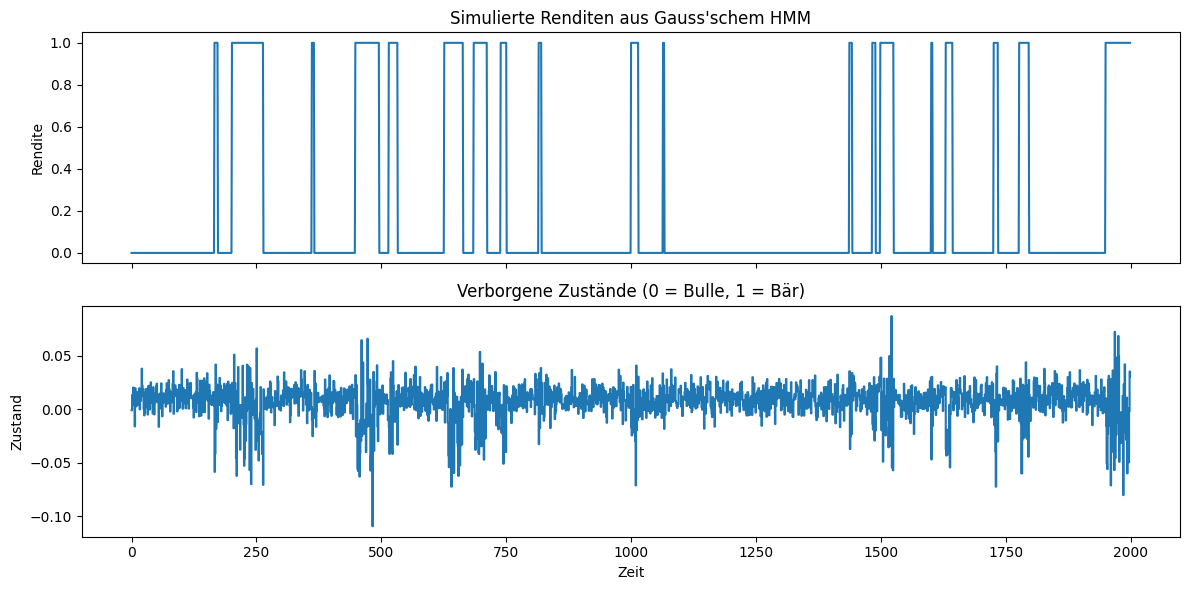

In [19]:

rng = np.random.default_rng(seed=42)

# --- Parameter-Setup ---

# Zustand 0: Bullenmarkt
mu_bull = 0.01    # > 0
sigma_bull = 0.01 # kleinere Volatilität

# Zustand 1: Bärenmarkt
mu_bear = -0.005   # < 0 und |mu_bear| < |mu_bull|
sigma_bear = 0.03  # größere Volatilität

# Übergangsmatrix:
# Reihen: aktueller Zustand, Spalten: nächster Zustand
# [ p(Bulle->Bulle)  p(Bulle->Bär) ]
# [ p(Bär->Bulle)    p(Bär->Bär)   ]
transmat = np.array([
    [1 - 0.01, 0.01],  # Bulle bleibt mit 0.99, wechselt mit 0.01 zu Bär
    [0.05, 1 - 0.05],  # Bär wechselt mit 0.05 zu Bulle, bleibt mit 0.95
])

# Startwahrscheinlichkeiten – z.B. hoher Start im Bullenmarkt
startprob = np.array([0.9, 0.1])

# --- HMM definieren ---

model = GaussianHMM(
    n_components=2,
    covariance_type="diag",
    init_params="",  # ganz wichtig: verhindert, dass hmmlearn unsere Vorgaben überschreibt
    random_state=42,
)

# Mittelwerte (je Zustand ein Vektor)
model.means_ = np.array([[mu_bull], [mu_bear]])           # shape (2, 1)

# Varianzen (sigma^2), diag-Covariance ⇒ shape (2, 1)
model.covars_ = np.array([[sigma_bull**2], [sigma_bear**2]])

model.transmat_ = transmat
model.startprob_ = startprob

# --- Simulation ---

n_samples = 2000  # Länge der simulierten Zeitreihe

hidden_states, observations = model.sample(n_samples)

# observations: shape (n_samples, 1) → Renditen
returns = observations.ravel()  # zu 1D machen

# --- Optional: kleine Visualisierung ---

time = np.arange(n_samples)

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# (1) Renditen
ax[0].plot(time, returns)
ax[0].set_title("Simulierte Renditen aus Gauss'schem HMM")
ax[0].set_ylabel("Rendite")

# (2) Hidden States (0 = Bulle, 1 = Bär)
ax[1].step(time, hidden_states, where="post")
ax[1].set_title("Verborgene Zustände (0 = Bulle, 1 = Bär)")
ax[1].set_xlabel("Zeit")
ax[1].set_ylabel("Zustand")

plt.tight_layout()
plt.show()


In [25]:
import pandas as pd
import numpy as np
import os, sys
sys.path.insert(0, os.path.abspath('../..'))
import source.data_preparation as dp
import source.modelling_classification as modl
import torch
from chronos import BaseChronosPipeline
import torch
from momentfm import MOMENTPipeline
from sklearn.metrics import roc_curve

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from momentfm import MOMENTPipeline
import matplotlib.pyplot as plt


In [17]:
def moment_cls_oos(
    data,
    start_oos="1965-01-01",
    min_context=120,
    seq_len=256,
    batch_size=64,
    epochs_per_step=10,
    lr=5e-5,
    quiet=False,
    model_id="AutonLab/MOMENT-1-large",
    tune_threshold='youden',      # 'youden' | 'majority' | None
    use_class_weight=True,
    train_first_step_only=True,
    train_every_n_steps=None,
):
    """
    Expanding-window one-step-ahead OOS classification with MOMENT.

    - Inputs X_t: past seq_len values of *continuous* equity_premium.
    - Target y_t: equity_premium_c[t] (0/1) = sign of equity_premium[t].
    """

    # ---- device ----
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    if not quiet:
        print(f"[MOMENT-CLS] device={device}")

    # ---- data ----
    df = (
        data.sort_index()[["equity_premium", "equity_premium_c"]]
            .dropna()
            .asfreq("MS")
    )
    y_cont = df["equity_premium"].astype("float32")
    y_cls  = df["equity_premium_c"].astype("int64")

    start_oos = pd.Timestamp(start_oos)
    test_idx  = y_cls.index[y_cls.index >= start_oos]

    if not quiet:
        print(f"[MOMENT-CLS] span {y_cls.index[0].date()} → {y_cls.index[-1].date()}  n={len(y_cls)}")

    # ---- model ----
    model = MOMENTPipeline.from_pretrained(
        model_id,
        model_kwargs={"task_name": "classification", "n_channels": 1, "num_class": 2},
    )
    model.init()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # ---- helpers ----
    def make_windows(series_cont, series_cls, upto_pos):
        x_arr = series_cont.iloc[:upto_pos].to_numpy(dtype=np.float32)
        y_arr = series_cls.iloc[:upto_pos].to_numpy(dtype=np.int64)
        Xs, ys = [], []
        for t in range(seq_len, len(x_arr)):
            Xs.append(x_arr[t-seq_len:t])
            ys.append(y_arr[t])
        if not Xs:
            return None, None
        X = torch.from_numpy(np.stack(Xs)).float().unsqueeze(1)
        y = torch.from_numpy(np.asarray(ys, dtype=np.int64))
        return X, y

    def make_ctx(series_cont, upto_pos):
        hist = series_cont.iloc[:upto_pos].to_numpy(dtype=np.float32)
        if hist.size < seq_len:
            hist = np.hstack([np.zeros(seq_len - hist.size, np.float32), hist])
        else:
            hist = hist[-seq_len:]
        return torch.from_numpy(hist).view(1, 1, seq_len)

    # ---- expanding OOS ----
    probs, trues, dates, thr_list = [], [], [], []
    has_trained_once = False
    i= -1
    for date_t in test_idx:
        i+=1
        
        if not quiet:
            print(date_t)

        pos = y_cls.index.get_loc(date_t)
        if pos < max(min_context, seq_len + 1):
            continue

        X_train, y_train = make_windows(y_cont, y_cls, upto_pos=pos)
        if X_train is None or len(X_train) < 10 or len(torch.unique(y_train)) < 2:
            continue

        # --- train block (optional per-step) ---
        if (not train_first_step_only) or (train_first_step_only and not has_trained_once):
            if train_every_n_steps is not None:
                if i % train_every_n_steps != 0:
                    continue
            print("training")
            if use_class_weight:
                n1 = (y_train == 1).sum().item()
                n0 = (y_train == 0).sum().item()
                w0 = (n1 + n0) / (2.0 * max(1, n0))
                w1 = (n1 + n0) / (2.0 * max(1, n1))
                class_weight = torch.tensor([w0, w1], dtype=torch.float32, device=device)
                criterion = nn.CrossEntropyLoss(weight=class_weight)
            else:
                criterion = nn.CrossEntropyLoss()

            train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

            model.train()
            for _ in range(epochs_per_step):
                for xb, yb in train_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    xb.requires_grad = True
                    out = model(x_enc=xb)
                    loss = criterion(out.logits, yb)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            has_trained_once = True

        # --- threshold tuning ---
        thr = 0.5
        if tune_threshold is not None:
            model.eval()
            with torch.inference_mode():
                p_tr = []
                for xb, yb in DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size):
                    pr = torch.softmax(model(x_enc=xb.to(device)).logits, dim=1)[:, 1].cpu().numpy()
                    p_tr.append(pr)
                p_tr = np.concatenate(p_tr)
                y_tr = y_train.numpy()

            if tune_threshold == "majority":
                thr = float(y_tr.mean())
            elif tune_threshold == "youden":
                fpr, tpr, th = roc_curve(y_tr, p_tr)
                j = tpr - fpr
                thr = float(th[np.argmax(j)]) if len(th) else 0.5

        thr_list.append(thr)

        # --- predict ---
        model.eval()
        with torch.inference_mode():
            x_ctx = make_ctx(y_cont, upto_pos=pos).to(device)
            p1 = torch.softmax(model(x_enc=x_ctx).logits, dim=1)[0, 1].item()

        probs.append(float(p1))
        trues.append(int(y_cls.iloc[pos]))
        dates.append(date_t)

    if not probs:
        raise RuntimeError("No valid predictions; increase history or lower min_context.")

    y_prob = np.asarray(probs, float)
    y_true = np.asarray(trues, int)
    thr_arr = np.asarray(thr_list, float)
    dates  = pd.DatetimeIndex(dates)

    # ✅ use dynamic threshold per-step
    y_hat = (y_prob >= thr_arr).astype(int)
    acc = (y_hat == y_true).mean()
    brier = np.mean((y_prob - y_true)**2)

    if not quiet:
        print(f"[MOMENT-CLS] steps={len(y_true)}  Acc={acc:.4f}  Brier={brier:.4f}")

    return acc, brier, y_true, y_prob, thr_arr, dates

import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM

def simulate_hmm_equity_premium(
    n_samples=2000,
    start_date="1950-01-01",
    freq="MS",
    seed=42,
):
    rng = np.random.default_rng(seed)

    # --- Parameter-Setup ---

    # # Zustand 0: Bullenmarkt
    mu_bull = 0.01
    sigma_bull = 0.01

    # Zustand 1: Bärenmarkt
    mu_bear = -0.005          # |mu_bear| < |mu_bull|
    sigma_bear = 0.03         # höhere Volatilität
     # Bull market (stronger returns, low volatility)
    # mu_bull = 0.015
    # sigma_bull = 0.01

    # # Bear market (more negative returns, moderate volatility)
    # mu_bear = -0.01
    # sigma_bear = 0.02
    transmat = np.array([
        [1 - 0.01, 0.01],     # Bulle -> Bulle/Bär
        [0.05, 1 - 0.05],     # Bär -> Bulle/Bär
    ])

    startprob = np.array([0.9, 0.1])

    model = GaussianHMM(
        n_components=2,
        covariance_type="diag",
        init_params="",
        random_state=seed,
    )

    model.means_ = np.array([[mu_bull], [mu_bear]])            # shape (2, 1)
    model.covars_ = np.array([[sigma_bull**2], [sigma_bear**2]])
    model.transmat_ = transmat
    model.startprob_ = startprob

    hidden_states, observations = model.sample(n_samples)
    returns = observations.ravel().astype(np.float32)

    # Datum-Index
    dates = pd.date_range(start=start_date, periods=n_samples, freq=freq)

    # WICHTIG: gleiche Spaltennamen wie im MOMENT-Code
    df = pd.DataFrame(
        {
            "equity_premium": returns,
            "equity_premium_c": (returns > 0).astype(int),
        },
        index=dates,
    )

    return df, hidden_states
# hier deine Funktion moment_cls_oos ausführen, unverändert




In [33]:
df_sim, z = simulate_hmm_equity_premium(
    n_samples=500,
    start_date="1950-01-01",
    freq="MS",
)

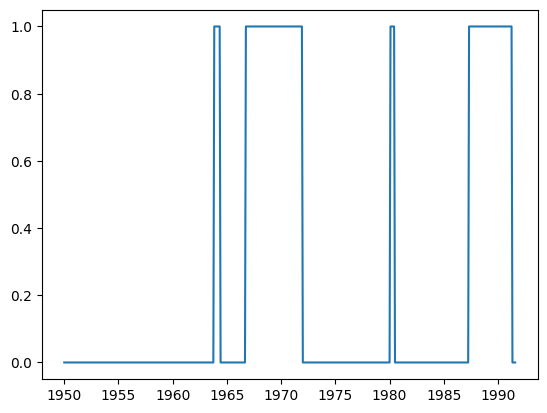

In [34]:
plt.plot(df_sim.index, df_sim["equity_premium"], label="Simulated Equity Premium")

In [35]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score


def logit_cls_oos(
    data,
    start_oos="1965-01-01",
    min_context=120,
    seq_len=64,
    C=1.0,
    penalty="l2",
    max_iter=1000,
    quiet=False,
):
    """
    Expanding-window one-step-ahead OOS classification baseline:
    Logistic regression on past seq_len returns.

    - Inputs X_t: vector of past seq_len values of equity_premium.
    - Target y_t: equity_premium_c[t] (0/1).
    """

    # ---- data: continuous + class labels ----
    df = (
        data.sort_index()[["equity_premium", "equity_premium_c"]]
            .dropna()
            .asfreq("MS")
    )

    # (optional but recommended) standardize series globally
    ep = df["equity_premium"].astype("float32")
    ep_std = (ep - ep.mean()) / ep.std()
    y_cont = ep_std
    y_cls  = df["equity_premium_c"].astype("int64")

    start_oos = pd.Timestamp(start_oos)
    test_idx  = y_cls.index[y_cls.index >= start_oos]

    if not quiet:
        print(f"[LOGIT-CLS] span {y_cls.index[0].date()} → {y_cls.index[-1].date()}  n={len(y_cls)}")

    def make_windows(series_cont, series_cls, upto_pos):
        """
        Build supervised windows from history up to (but excluding) index 'upto_pos'.

        For t in [seq_len, upto_pos-1]:
            X_t = equity_premium[t-seq_len : t]   (vector length seq_len)
            y_t = equity_premium_c[t]
        """
        x_arr = series_cont.iloc[:upto_pos].to_numpy(dtype=np.float32)
        y_arr = series_cls.iloc[:upto_pos].to_numpy(dtype=np.int64)

        Xs, ys = [], []
        for t in range(seq_len, len(x_arr)):
            Xs.append(x_arr[t-seq_len:t])
            ys.append(y_arr[t])
        if not Xs:
            return None, None

        X = np.stack(Xs)              # (N, seq_len)
        y = np.asarray(ys, int)       # (N,)
        return X, y

    def make_ctx(series_cont, upto_pos):
        """
        Single 1D context vector of length seq_len up to t-1 for predicting y_t.
        """
        hist = series_cont.iloc[:upto_pos].to_numpy(dtype=np.float32)
        if hist.size < seq_len:
            hist = np.hstack([np.zeros(seq_len - hist.size, np.float32), hist])
        else:
            hist = hist[-seq_len:]
        return hist.reshape(1, -1)    # (1, seq_len)

    probs, trues, dates = [], [], []

    for date_t in test_idx:
        if not quiet:
            print(date_t)

        pos = y_cls.index.get_loc(date_t)
        if pos < max(min_context, seq_len + 1):
            continue

        # build training windows from all history strictly before t
        X_train, y_train = make_windows(y_cont, y_cls, upto_pos=pos)
        if X_train is None or len(X_train) < 10 or len(np.unique(y_train)) < 2:
            continue

        # standardize features using *only* training history
        scaler = StandardScaler()
        X_train_std = scaler.fit_transform(X_train)

        # fit logistic regression
        clf = LogisticRegression(
            C=C,
            penalty=penalty,
            solver="lbfgs",
            max_iter=max_iter,
        )
        clf.fit(X_train_std, y_train)

        # build current context and predict
        X_ctx = make_ctx(y_cont, upto_pos=pos)
        X_ctx_std = scaler.transform(X_ctx)
        p1 = clf.predict_proba(X_ctx_std)[0, 1]

        probs.append(float(p1))
        trues.append(int(y_cls.iloc[pos]))
        dates.append(date_t)

    if not probs:
        raise RuntimeError("No valid predictions; increase history or lower min_context.")

    y_prob = np.asarray(probs, float)
    y_true = np.asarray(trues, int)
    dates  = pd.DatetimeIndex(dates)

    y_hat = (y_prob >= 0.5).astype(int)
    acc = (y_hat == y_true).mean()
    brier = np.mean((y_prob - y_true) ** 2)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = np.nan

    if not quiet:
        print(f"[LOGIT-CLS] steps={len(y_true)}  Acc={acc:.4f}  Brier={brier:.4f}  AUC={auc:.4f}")

    return acc, brier, auc, y_true, y_prob, dates
# --- baseline: logistic regression ---
df_sim, z = simulate_hmm_equity_premium(
    n_samples=500,
    start_date="1950-01-01",
    freq="MS",
)
acc_logit, brier_logit, auc_logit, y_true_l, y_prob_l, dts_l = logit_cls_oos(
    df_sim,
    start_oos="1965-01-01",
    min_context=120,
    seq_len=64,
    quiet=True,
)

print(f"[BASELINE-LOGIT-HMM] Acc={acc_logit:.4f}  Brier={brier_logit:.4f}  AUC={auc_logit:.4f}")


# --- MOMENT: same data, same horizon ---
acc_mom, brier_m, y_true_m, y_prob_m, thr_arr_m, dates_m = moment_cls_oos(
    df_sim,
    start_oos="1965-01-01",
    min_context=120,
    seq_len=64,
    batch_size=64,
    epochs_per_step=10,
    lr=1e-4,
    quiet=False,
    model_id="AutonLab/MOMENT-1-large",
    tune_threshold='youden',       # or 'youden'
    use_class_weight=True,
    train_first_step_only=False
)

y_hat_m = (y_prob_m >= 0.5).astype(int)
brier_m = np.mean((y_prob_m - y_true_m) ** 2)

print(f"[MOMENT-HMM]          Acc={acc_mom:.4f}  Brier={brier_m:.4f}")


[BASELINE-LOGIT-HMM] Acc=0.9781  Brier=0.0212  AUC=0.9785
[MOMENT-CLS] device=mps
[MOMENT-CLS] span 1950-01-01 → 1991-08-01  n=500


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


1965-01-01 00:00:00
training


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


1965-02-01 00:00:00
training


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


1965-03-01 00:00:00
training


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


1965-04-01 00:00:00
training


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


1965-05-01 00:00:00
training


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


1965-06-01 00:00:00
training


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


1965-07-01 00:00:00
training


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


KeyboardInterrupt: 

In [ ]:
print("share of true 1s:", y_true_m.mean())
print("share of predicted 1s:", y_hat_m.mean())
print("min/max prob:", y_prob_m.min(), y_prob_m.max())

In [8]:
# ============================================================
# HMM simulation + logit baseline + MOMENT classification test
# ============================================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader
from hmmlearn.hmm import GaussianHMM

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    brier_score_loss,
    roc_auc_score,
)

from momentfm import MOMENTPipeline


# ---------------------------
# 1. Simulate HMM time series
# ---------------------------

def simulate_hmm_equity_premium(
    n_samples=1000,
    start_date="1950-01-01",
    freq="MS",
    seed=42,
):
    ...
    model.startprob_ = startprob

    # ✅ Correct order: observations first, then states
    observations, hidden_states = model.sample(n_samples)
    returns = observations.ravel().astype(np.float32)

    dates = pd.date_range(start=start_date, periods=n_samples, freq=freq)

    df = pd.DataFrame(
        {
            "equity_premium": returns,
            "equity_premium_c": (returns > 0).astype(int),
        },
        index=dates,
    )

    return df, hidden_states



# ------------------------------------
# 2. Windowing helpers (same for both)
# ------------------------------------

def make_windows(series_cont, series_cls, seq_len):
    """
    Build supervised windows:

    For t in [seq_len, T-1]:
        X_t = cont[t-seq_len : t]
        y_t = cls[t]

    Returns:
        X: (N, seq_len)
        y: (N,)
    """
    x_arr = series_cont.to_numpy(dtype=np.float32)
    y_arr = series_cls.to_numpy(dtype=np.int64)

    Xs, ys = [], []
    for t in range(seq_len, len(x_arr)):
        Xs.append(x_arr[t - seq_len: t])
        ys.append(y_arr[t])

    if not Xs:
        return None, None

    X = np.stack(Xs)         # (N, seq_len)
    y = np.asarray(ys, int)  # (N,)
    return X, y


# -----------------------------
# 3. Logistic regression baseline
# -----------------------------

def run_logit_baseline(df, seq_len=64, split_date="1975-01-01"):
    """
    Fixed train/test split logistic regression baseline.
    """
    df = df.sort_index()[["equity_premium", "equity_premium_c"]].dropna().asfreq("MS")

    # Standardize returns (important!)
    ep = df["equity_premium"].astype("float32")
    ep_std = (ep - ep.mean()) / ep.std()

    cls = df["equity_premium_c"].astype("int64")

    # Build windows on the *whole* series
    X_all, y_all = make_windows(ep_std, cls, seq_len=seq_len)

    # Align split: find index of split date (in original series), convert to window index
    split_ts = pd.Timestamp(split_date)
    pos_split = df.index.get_loc(split_ts)

    # Window index t corresponds to label at time index seq_len + t
    # So we need to find the window index where label date >= split_date
    # Label dates run from df.index[seq_len:] onward
    label_dates = df.index[seq_len:]
    split_win_idx = np.searchsorted(label_dates, split_ts)

    X_train, y_train = X_all[:split_win_idx], y_all[:split_win_idx]
    X_test, y_test = X_all[split_win_idx:], y_all[split_win_idx:]

    print(f"[LOGIT] train windows: {X_train.shape[0]}  test windows: {X_test.shape[0]}")

    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)

    clf = LogisticRegression(
        C=1.0,
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
    )
    clf.fit(X_train_std, y_train)

    prob_test = clf.predict_proba(X_test_std)[:, 1]
    y_hat = (prob_test >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_hat)
    brier = brier_score_loss(y_test, prob_test)
    try:
        auc = roc_auc_score(y_test, prob_test)
    except ValueError:
        auc = np.nan

    print(f"[LOGIT] Acc={acc:.4f}  Brier={brier:.4f}  AUC={auc:.4f}")

    return acc, brier, auc, y_test, prob_test


# -------------------------
# 4. MOMENT classification
# -------------------------

def run_moment_cls(
    df,
    seq_len=64,
    split_date="1975-01-01",
    model_id="AutonLab/MOMENT-1-large",
    batch_size=64,
    epochs=10,
    lr=1e-4,
    device=None,
):
    """
    Fixed train/test split MOMENT classification.

    - Input: (N, 1, seq_len) continuous standardized returns
    - Target: 0/1 labels (sign of return)
    """

    # ----- device -----
    if device is None:
        if torch.backends.mps.is_available():
            device = torch.device("mps")
        elif torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
    print(f"[MOMENT] device={device}")

    df = df.sort_index()[["equity_premium", "equity_premium_c"]].dropna().asfreq("MS")

    ep = df["equity_premium"].astype("float32")
    # standardize, same as logit
    ep_std = (ep - ep.mean()) / ep.std()

    cls = df["equity_premium_c"].astype("int64")

    # Build windows
    X_all, y_all = make_windows(ep_std, cls, seq_len=seq_len)

    split_ts = pd.Timestamp(split_date)
    pos_split = df.index.get_loc(split_ts)

    label_dates = df.index[seq_len:]
    split_win_idx = np.searchsorted(label_dates, split_ts)

    X_train_np, y_train_np = X_all[:split_win_idx], y_all[:split_win_idx]
    X_test_np, y_test_np = X_all[split_win_idx:], y_all[split_win_idx:]

    print(f"[MOMENT] train windows: {X_train_np.shape[0]}  test windows: {X_test_np.shape[0]}")

    # Convert to tensors. MOMENT expects (B, C, L)
    X_train = torch.from_numpy(X_train_np).float().unsqueeze(1)  # (N, 1, seq_len)
    y_train = torch.from_numpy(y_train_np).long()

    X_test = torch.from_numpy(X_test_np).float().unsqueeze(1)
    y_test = torch.from_numpy(y_test_np).long()

    train_ds = TensorDataset(X_train, y_train)
    test_ds = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    # ----- MOMENT model -----
    model = MOMENTPipeline.from_pretrained(
        model_id,
        model_kwargs={
            "task_name": "classification",
            "n_channels": 1,
            "num_class": 2,
        },
    )
    model.init()
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # You can experiment with class weights if labels are imbalanced
    criterion = nn.CrossEntropyLoss()

    # ----- Training -----
    model.train()
    for epoch in range(epochs):
        losses = []
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # IMPORTANT: ensure grads flow with checkpointing
            xb.requires_grad_(True)

            out = model(x_enc=xb)
            loss = criterion(out.logits, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        print(f"[MOMENT] epoch {epoch+1}/{epochs}  loss={np.mean(losses):.4f}")

        # quick gradient sanity-check (only first epoch)
        if epoch == 0:
            some_grad = None
            for n, p in model.named_parameters():
                if p.grad is not None:
                    some_grad = p.grad.abs().mean().item()
                    print(f"[MOMENT] sample grad from '{n}': {some_grad:.3e}")
                    break
            if some_grad is None:
                print("[MOMENT] WARNING: no parameter gradients found!")

    # ----- Evaluation -----
    model.eval()
    all_probs = []
    all_y = []

    with torch.inference_mode():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = model(x_enc=xb)
            logits = out.logits
            prob = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            all_probs.append(prob)
            all_y.append(yb.numpy())

    prob_test = np.concatenate(all_probs)
    y_test = np.concatenate(all_y)
    y_hat = (prob_test >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_hat)
    brier = brier_score_loss(y_test, prob_test)
    try:
        auc = roc_auc_score(y_test, prob_test)
    except ValueError:
        auc = np.nan

    print(f"[MOMENT] Acc={acc:.4f}  Brier={brier:.4f}  AUC={auc:.4f}")

    return acc, brier, auc, y_test, prob_test


# ======================
# 5. Run everything once
# ======================

if __name__ == "__main__":
    # Simulate HMM data
    df_sim, hidden_states = simulate_hmm_equity_premium(
        n_samples=1000,
        start_date="1950-01-01",
        freq="MS",
        seed=42,
    )

    print("Hidden state frequencies:", np.bincount(hidden_states))

    # Baseline logistic regression
    print("\n=== Logistic regression baseline on HMM ===")
    acc_logit, brier_logit, auc_logit, y_test_logit, prob_logit = run_logit_baseline(
        df_sim,
        seq_len=64,
        split_date="1975-01-01",
    )

    # MOMENT classification
    print("\n=== MOMENT classification on HMM ===")
    acc_mom, brier_mom, auc_mom, y_test_mom, prob_mom = run_moment_cls(
        df_sim,
        seq_len=64,
        split_date="1975-01-01",
        model_id="AutonLab/MOMENT-1-large",
        batch_size=64,
        epochs=10,
        lr=1e-4,
    )

    print("\n=== Summary ===")
    print(f"LOGIT  : Acc={acc_logit:.4f}, Brier={brier_logit:.4f}, AUC={auc_logit:.4f}")
    print(f"MOMENT : Acc={acc_mom:.4f}, Brier={brier_mom:.4f}, AUC={auc_mom:.4f}")


NameError: name 'startprob' is not defined

In [ ]:
plt.hist(y_test_mom)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
# from tabpfn import TabPFNClassifier

import numpy as np
import pandas as pd


def tabpfn_cls_oos(
    data,
    start_oos="1965-01-01",
    min_context=120,
    seq_len=256,
    tune_threshold="youden",   # 'youden' | 'majority' | None
    quiet=False,
):
    """
    Expanding-window one-step-ahead OOS classification using TabPFN on lag features.

    - Inputs X_t: past seq_len values of *continuous* equity_premium (standardized).
    - Target y_t: equity_premium_c[t] (0/1) = sign of equity_premium[t].

    Returns:
        acc      : overall accuracy with dynamic threshold
        brier    : Brier score
        y_true   : np.array of true labels (0/1)
        y_prob   : np.array of predicted P(y=1)
        thr_arr  : np.array of thresholds used per step
        dates    : DatetimeIndex of OOS timestamps
    """

    # ---- data: continuous + class labels ----
    df = (
        data.sort_index()[["equity_premium", "equity_premium_c"]]
        .dropna()
        .asfreq("MS")
    )

    # Standardize returns globally (like logit baseline)
    ep = df["equity_premium"].astype("float32")
    ep_std = (ep - ep.mean()) / ep.std()

    y_cont = ep_std
    y_cls  = df["equity_premium_c"].astype("int64")

    start_oos = pd.Timestamp(start_oos)
    test_idx  = y_cls.index[y_cls.index >= start_oos]

    if not quiet:
        print(f"[TabPFN-CLS] span {y_cls.index[0].date()} → {y_cls.index[-1].date()}  n={len(y_cls)}")

    # ---- helpers ----
    def make_windows(series_cont, series_cls, upto_pos):
        """
        Build supervised windows from history up to (but excluding) index 'upto_pos'.

        For t in [seq_len, upto_pos-1]:
            X_t = equity_premium_std[t-seq_len : t]   (vector length seq_len)
            y_t = equity_premium_c[t]
        """
        x_arr = series_cont.iloc[:upto_pos].to_numpy(dtype=np.float32)
        y_arr = series_cls.iloc[:upto_pos].to_numpy(dtype=np.int64)

        Xs, ys = [], []
        for t in range(seq_len, len(x_arr)):
            Xs.append(x_arr[t-seq_len:t])
            ys.append(y_arr[t])
        if not Xs:
            return None, None

        X = np.stack(Xs)             # (N, seq_len)
        y = np.asarray(ys, np.int64) # (N,)
        return X, y

    def make_ctx(series_cont, upto_pos):
        """
        Single 1D context vector of length seq_len up to t-1 for predicting y_t.
        """
        hist = series_cont.iloc[:upto_pos].to_numpy(dtype=np.float32)
        if hist.size < seq_len:
            hist = np.hstack([np.zeros(seq_len - hist.size, np.float32), hist])
        else:
            hist = hist[-seq_len:]
        return hist.reshape(1, -1)  # (1, seq_len)

    # ---- model (TabPFN) ----
    # instantiate once, reuse .fit() each step
    clf = TabPFNClassifier()  # you can pass device="cuda" etc. if your version supports it

    # ---- expanding OOS ----
    probs, trues, dates, thr_list = [], [], [], []

    for date_t in test_idx:
        if not quiet:
            print(date_t)

        pos = y_cls.index.get_loc(date_t)
        if pos < max(min_context, seq_len + 1):
            continue

        # build training windows from all history strictly before t
        X_train, y_train = make_windows(y_cont, y_cls, upto_pos=pos)
        if X_train is None or len(X_train) < 10 or len(np.unique(y_train)) < 2:
            continue

        # TabPFN handles numeric scales internally; we *could* scale,
        # but since we already standardized globally, we just fit directly:
        clf.fit(X_train, y_train)

        # ---- threshold tuning on past windows ----
        thr = 0.5
        if tune_threshold is not None:
            p_tr = clf.predict_proba(X_train)[:, 1]
            if tune_threshold == "majority":
                thr = float(y_train.mean())
            elif tune_threshold == "youden":
                fpr, tpr, th = roc_curve(y_train, p_tr)
                j = tpr - fpr
                thr = float(th[np.argmax(j)]) if len(th) else 0.5
        thr_list.append(thr)

        # ---- predict 1-step-ahead ----
        X_ctx = make_ctx(y_cont, upto_pos=pos)
        p1 = clf.predict_proba(X_ctx)[0, 1]

        probs.append(float(p1))
        trues.append(int(y_cls.iloc[pos]))
        dates.append(date_t)

    if not probs:
        raise RuntimeError("No valid TabPFN predictions; increase history or lower min_context.")

    # ---- results ----
    y_prob = np.asarray(probs, float)
    y_true = np.asarray(trues, int)
    thr_arr = np.asarray(thr_list, float)
    dates   = pd.DatetimeIndex(dates)

    y_hat = (y_prob >= thr_arr).astype(int)
    acc   = (y_hat == y_true).mean()
    brier = np.mean((y_prob - y_true) ** 2)

    if not quiet:
        print(f"[TabPFN-CLS] steps={len(y_true)}  Acc={acc:.4f}  Brier={brier:.4f}")

    return acc, brier, y_true, y_prob, thr_arr, dates
